In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 4.4 MB 18.0 MB/s 
     |████████████████████████████████| 1.2 MB 49.8 MB/s 
     |████████████████████████████████| 101 kB 7.9 MB/s 
     |████████████████████████████████| 596 kB 42.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=aee56a04df7baa77c8e5faf186cc08298a3ded3d6107203d236cb5b883809101
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from scipy.sparse.csr import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_expedientes_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_capitulo,id_concepto,id_partida_generica,descripcion,clean_text
0,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN LA COO...,servicio profesional consistente coordinación ...
1,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar des...
2,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar man...
3,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar log...
4,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar log...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617067 entries, 0 to 617066
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id_capitulo          617067 non-null  int64 
 1   id_concepto          617067 non-null  int64 
 2   id_partida_generica  617067 non-null  int64 
 3   descripcion          617067 non-null  object
 4   clean_text           617067 non-null  object
dtypes: int64(3), object(2)
memory usage: 23.5+ MB


In [ ]:
df.isnull().sum()

id_capitulo            0
id_concepto            0
id_partida_generica    0
descripcion            0
clean_text             0
dtype: int64

In [5]:
df = df.sample(n=100000, random_state=1)
df

,id_capitulo,id_concepto,id_partida_generica,descripcion,clean_text
218030,2000,2500,2530,AA-050GYR010-E202-2019 MEDICAMENTO,medicamento
140613,3000,3500,3580,LIMPIEZA EN EL AEROPUERTO INTERNACIONAL DE URU...,limpieza aeropuerto internacional uruapan
258520,2000,2100,2120,COMPRA DE CARTUCHOS DE TÓNER SOLICITADAS POR D...,comprar cartucho tóner solicitar diferente áre...
285545,3000,3300,3390,SERVICIOS PROFESIONALES PARA LA ELABORACIÓN DE...,servicio profesional elaboración avalúo
84700,2000,2500,2530,IA-050GYR026-E4-2018 ADQUISICIÓN DE MEDICAMENTO,adquisición medicamento
...,...,...,...,...,...
108496,3000,3500,3550,Servicio de mantenimiento preventivo y correct...,servicio mantenimiento preventivo correctivo p...
103513,2000,2500,2540,MATERIAL DE CURACION DE ALTA ESPECIALIDAD,material curacion alto especialidad
151384,2000,2700,2710,Adquisicion de Camisetas Universitarias para A...,adquisicion camiseta universitario alumno nuev...
14795,2000,2600,2610,A-050GYR075-E001-2022 SUMINISTRO DE COMBUSTIBL...,suministrar combustible gasolina diesel


In [6]:
df.groupby(['id_capitulo']).count()['descripcion']

id_capitulo
2000    43057
3000    43432
5000     2766
6000    10745
Name: descripcion, dtype: int64

In [7]:
df.groupby(['id_concepto']).count()['descripcion']

id_concepto
2100     3094
2200     1673
2300    17631
2400     1526
2500    15012
2600      990
2700     1131
2800      108
2900     1892
3100     2071
3200     1980
3300    24875
3400      903
3500    10347
3600     1230
3700      509
3800      489
3900     1028
5100      788
5200      146
5300      825
5400      274
5500       20
5600      504
5700       16
5800      120
5900       73
6100     7780
6200     2754
6300      211
Name: descripcion, dtype: int64

In [8]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['descripcion'] # Text
Y = df['id_concepto'] # Labels

In [9]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/100.0)))

In [12]:
#sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
#sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
sbert_model = SentenceTransformer("PlanTL-GOB-ES/roberta-base-bne")#BETO, ROBERTA, RIGOBERTA

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/PlanTL-GOB-ES_roberta-base-bne. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/PlanTL-GOB-ES_roberta-base-bne were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from t

In [13]:
def get_sentence_embeding(sentences, sbert_model):
    return sbert_model.encode(sentences)

In [14]:
s = get_sentence_embeding([
    "TRABAJOS DE REHABILTACIÓN Y MANTTO",
    "ADQUISICION DE INSUMOS DE LISOSOMALES",
    "SERVICIO DE ARRENDAMIENTO INTEGRAL",
    "Materiales para mantenimiento de lámparas"
    ], sbert_model
)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([s[0]],[s[2]])

array([[0.95458317]], dtype=float32)

In [16]:
sentence_embeddings = sbert_model.encode(df['descripcion'].values[0:5])

In [17]:
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 768
Sample BERT embedding vector - note includes negative values [-1.05245955e-01 -3.39456112e-03  4.26925607e-02 -9.73169431e-02
  1.82238311e-01  1.48919493e-01  7.79805630e-02  4.85973805e-02
  1.07530028e-01 -1.70605201e-02  3.36431488e-02 -3.65118608e-02
  3.40902666e-03  9.76070538e-02  1.07846908e-01  1.14464648e-01
  1.39525801e-01 -2.57013619e-01 -8.57024714e-02  3.52072604e-02
 -7.12574124e-02 -1.48584023e-01 -6.77077547e-02  3.19338702e-02
 -5.88138625e-02 -1.34376986e-02  1.79332376e-01 -2.32122019e-02
  1.48520350e-01 -8.94637480e-02 -1.05155930e-02 -2.04925373e-01
 -6.55613989e-02 -3.16228084e-02  3.89495902e-02 -1.61734849e-01
 -2.15085417e-01  1.07829772e-01 -4.52296920e-02 -1.12805277e-01
  1.05726346e-01  4.21209745e-02  1.00338936e-01  2.60059983e-02
 -2.02168778e-01  3.63105796e-02 -4.98277664e+00 -5.08864447e-02
 -4.41054404e-01 -1.76730320e-01  8.65087360e-02  6.51026443e-02
 -7.98957348e-02 -1.10366739e-01 -5.55901974e-02  1.

Solamento 5 horas en procesar la vectorización :(

In [18]:
X = X.apply(lambda description: get_sentence_embeding(description, sbert_model))

In [19]:
#to sparse matrix
X_vect = csr_matrix(pd.DataFrame(np.vstack(X)))

In [20]:
X_vect

<100000x768 sparse matrix of type '<class 'numpy.float32'>'
	with 76800000 stored elements in Compressed Sparse Row format>

In [21]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X_vect, Y, stratify=Y, test_size=0.2, shuffle = True, random_state=0)

In [ ]:
#X_train_vec = pd.DataFrame(np.vstack( X_train.apply(lambda description: get_sentence_embeding(description, sbert_model))))
#X_test_vec = pd.DataFrame(np.vstack( X_test.apply(lambda description: get_sentence_embeding(description, sbert_model))))

In [22]:
X_train.shape

(80000, 768)

In [23]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [24]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [25]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

##Scaler

In [26]:
from sklearn.preprocessing import StandardScaler 
#removes the mean and scales the data to unit variance. [-0.2, 0.2] range
scaler = StandardScaler(with_mean=False).fit(X_vect)
X_train_SS = scaler.transform(X_train)
X_test_SS = scaler.transform(X_test)

##MultinomialNB

In [27]:
from sklearn.naive_bayes import GaussianNB
parametersMNB = { 
                 'var_smoothing':[1e-9]
                }
modelMNB = GaussianNB()

In [29]:
clf_MNB_GS = GridSearchCV(modelMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train_SS.toarray(), y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09]}, verbose=3)

In [30]:
# Let's see the results
y_pred = clf_MNB_GS.predict(X_test_SS.toarray())
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'var_smoothing': 1e-09}

Grid scores on testing set:

0.449 (+/-0.021) for {'var_smoothing': 1e-09}

best score:  0.44883754607833765

Grid times on testing set:

2.925 seconds (+/-2.993) for {'var_smoothing': 1e-09}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.36172479847825334, 'accuracy': 0.45125}
              precision    recall  f1-score   support

          21       0.51      0.28      0.36       619
          22       0.56      0.28      0.37       335
          23       0.91      0.92      0.92      3526
          24       0.22      0.31      0.26       305
          25       0.78      0.50      0.61      3002
          26       0.29      0.53      0.38       198
          27       0.58      0.17      0.26       226
          28       0.01      0.38      0.02        21
          29       0.29      0.29

<Figure size 432x288 with 0 Axes>

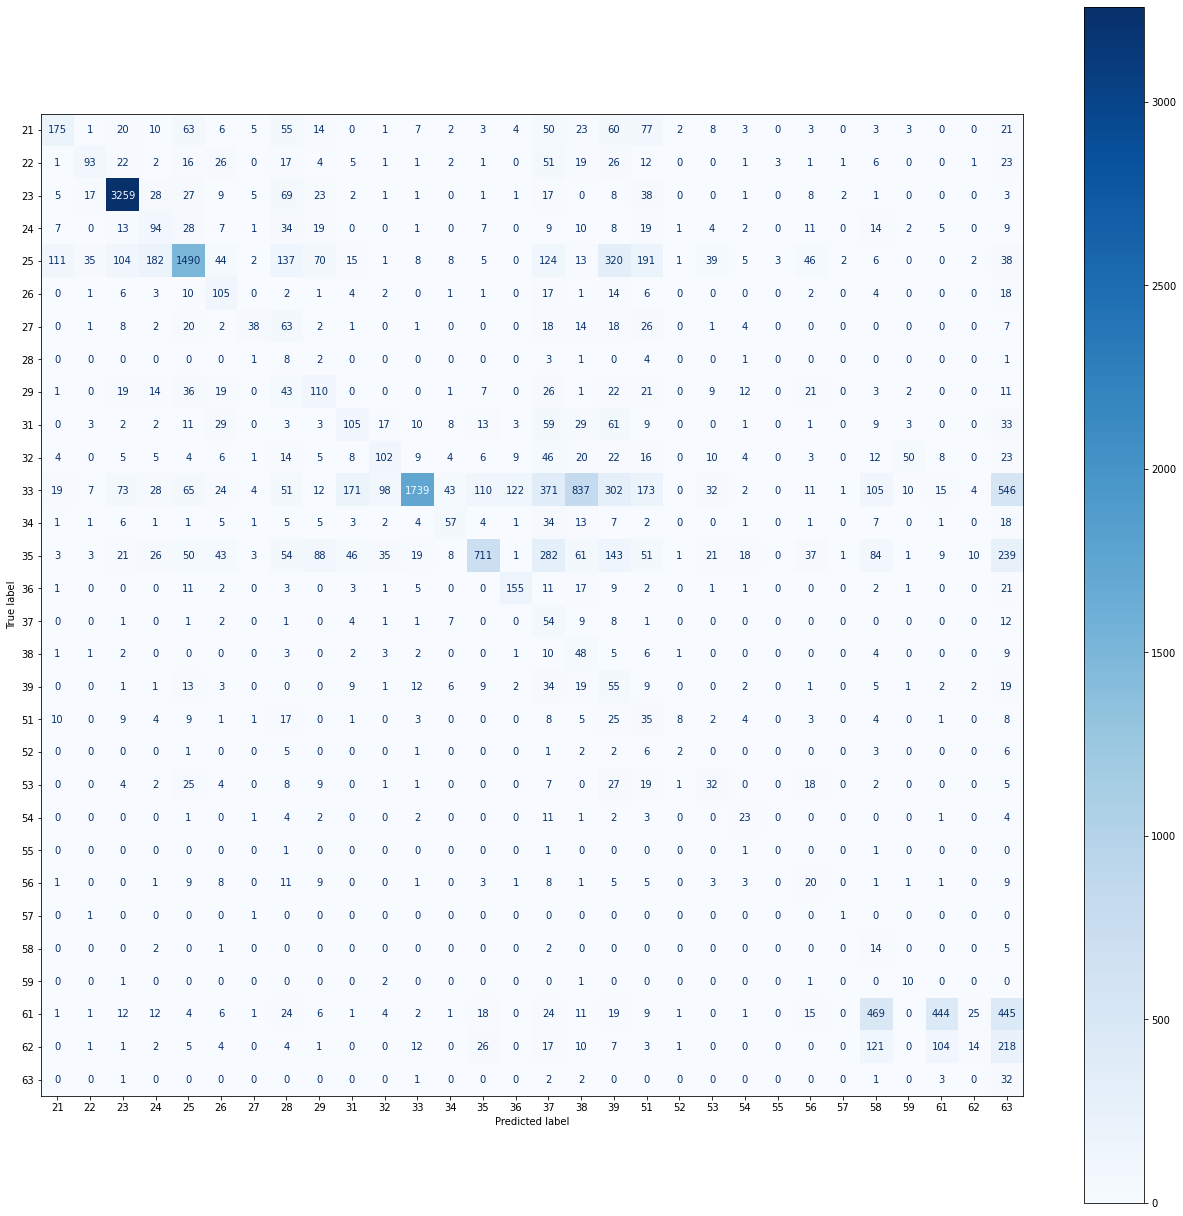

In [31]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##LinearSVM

In [32]:
#For large datasets consider using LinearSVC = SGDClassifier with loss hinge and penalty l2
parametersSVM = { 
                 'max_iter':[100, 200, 300, 500]
                 }
modelSVM = SGDClassifier(loss='hinge', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [33]:
#Model and hyperparameters
clf_GS_SVM = GridSearchCV(modelSVM, parametersSVM, cv=2, n_jobs=-1, verbose=10)
clf_GS_SVM.fit(X_train_SS, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 232.46, NNZs: 768, Bias: -0.102318, T: 72000, Avg. loss: 65.933556
Total training time: 0.28 seconds.
Norm: 331.60, NNZs: 768, Bias: -0.109016, T: 72000, Avg. loss: 57.085498
Total training time: 0.28 seconds.
-- Epoch 2
-- Epoch 2
Norm: 158.61, NNZs: 768, Bias: -0.102478, T: 144000, Avg. loss: 8.255900
Total training time: 0.83 seconds.
Norm: 218.47, NNZs: 768, Bias: -0.110582, T: 144000, Avg. loss: 5.790244
Total training time: 0.82 seconds.
-- Epoch 3
-- Epoch 3
Norm: 124.28, NNZs: 768, Bias: -0.101918, T: 216000, Avg. loss: 4.640857
Total training time: 1.37 seconds.
Norm: 168.24, NNZs: 768, Bias: -0.110598, T: 216000, Avg. loss: 3.262653
Total training time: 1.34 seconds.
-- Epoch 4
-- Epoch 4
Norm: 105.52, NNZs: 768, Bias: -0.102394, T: 288000, Avg. loss: 3.192565
Total training time: 1.92 seconds.
Norm: 143.27, NNZs: 768, Bias: -0.110328, T: 288000, Avg. loss: 2.249626
Total training time: 1.89 seconds.
-- Epoch 5
-- Epoch 5
Norm: 93.23, NNZs: 768, Bi

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.0s finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, n_jobs=-1,
                                     random_state=42, verbose=2),
             n_jobs=-1, param_grid={'max_iter': [100, 200, 300, 500]},
             verbose=10)

In [34]:
# Let's see the results
y_pred = clf_GS_SVM.predict(X_test_SS)
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'max_iter': 100}

Grid scores on testing set:

0.416 (+/-0.543) for {'max_iter': 100}
0.416 (+/-0.543) for {'max_iter': 200}
0.416 (+/-0.543) for {'max_iter': 300}
0.416 (+/-0.543) for {'max_iter': 500}

best score:  0.416425

Grid times on testing set:

58.525 seconds (+/-0.363) for {'max_iter': 100}
50.915 seconds (+/-0.332) for {'max_iter': 200}
46.642 seconds (+/-0.271) for {'max_iter': 300}
47.641 seconds (+/-0.088) for {'max_iter': 500}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.2796114543878894, 'accuracy': 0.29305}
              precision    recall  f1-score   support

          21       0.53      0.26      0.35       619
          22       0.54      0.28      0.37       335
          23       1.00      0.18      0.30      3526
          24       0.15      0.47      0.22       305
          25       0

<Figure size 432x288 with 0 Axes>

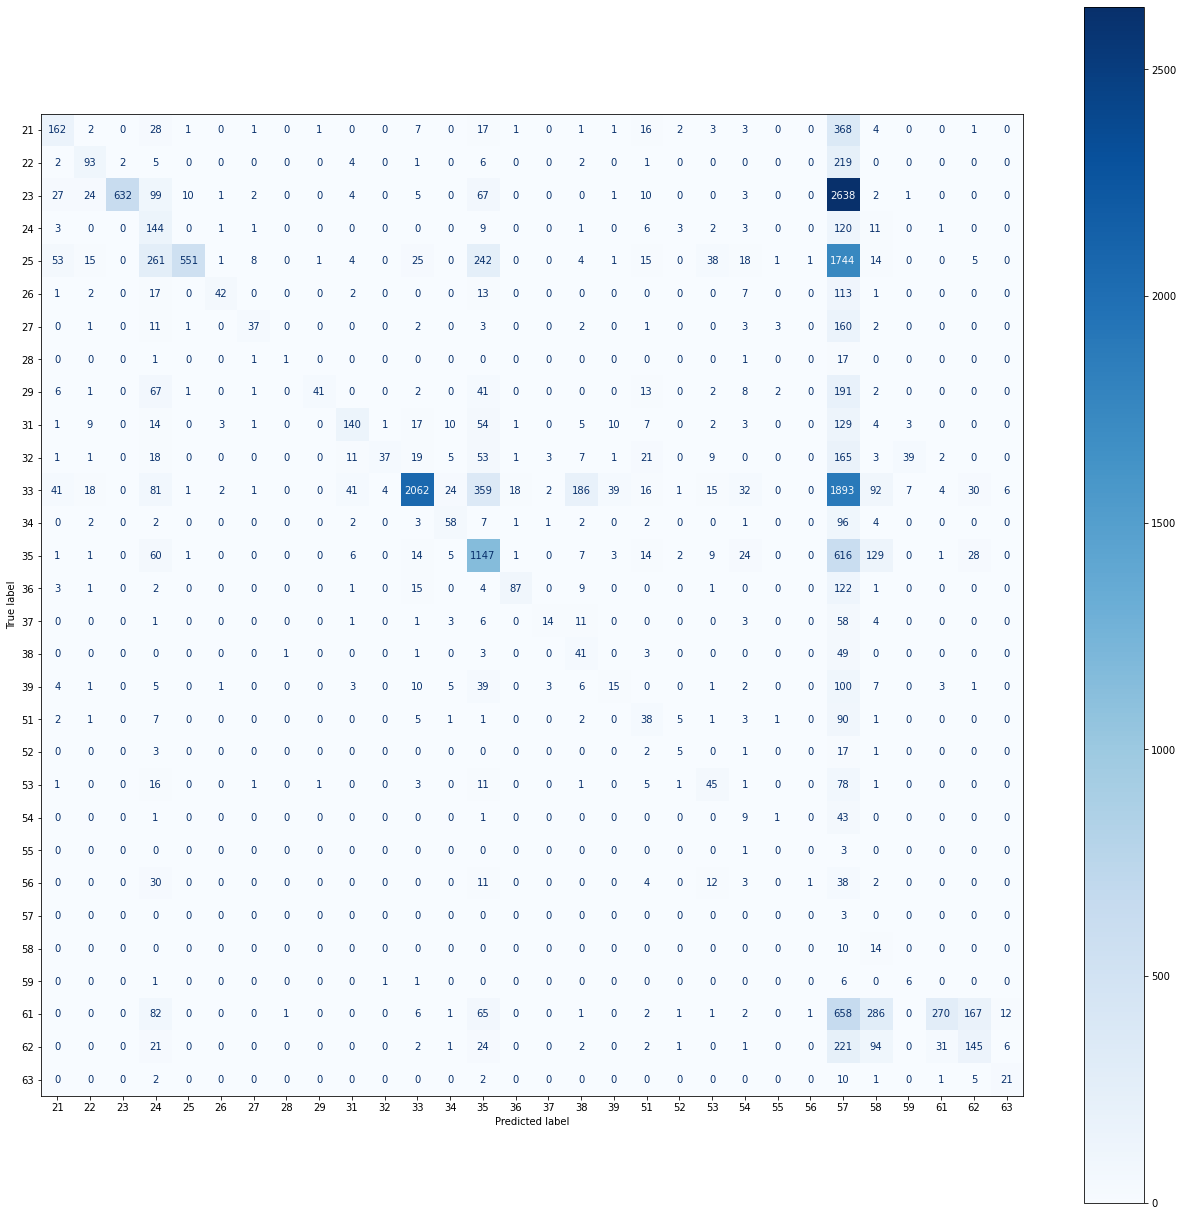

In [35]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##SGDClassifier

In [36]:
#Model and hyperparameters
parametersSGD = { 
                 'max_iter':[100, 200, 300, 500],
                 'loss':['modified_huber', 'squared_hinge', 'perceptron']
                 }
modelSGD = SGDClassifier(loss='perceptron', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [37]:
#Model and hyperparameters
clf_GS_SGD = GridSearchCV(modelSGD, parametersSGD, cv=2, n_jobs=-1, verbose=10)
clf_GS_SGD.fit(X_train_SS, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
Norm: 334.16, NNZs: 768, Bias: -0.108933, T: 72000, Avg. loss: 56.737919
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 217.40, NNZs: 768, Bias: -0.110620, T: 144000, Avg. loss: 5.825421
Total training time: 0.80 seconds.
-- Epoch 1
-- Epoch 3
Norm: 236.14, NNZs: 768, Bias: -0.102184, T: 72000, Avg. loss: 65.809948
Total training time: 0.27 seconds.
Norm: 168.54, NNZs: 768, Bias: -0.110686, T: 216000, Avg. loss: 3.201874
Total training time: 1.34 seconds.
-- Epoch 2
-- Epoch 4
Norm: 156.71, NNZs: 768, Bias: -0.102042, T: 144000, Avg. loss: 8.306335
Total training time: 0.81 seconds.
-- Epoch 3
Norm: 142.06, NNZs: 768, Bias: -0.110422, T: 288000, Avg. loss: 2.201893
Total training time: 1.90 seconds.
-- Epoch 5
Norm: 124.17, NNZs: 768, Bias: -0.102323, T: 216000, Avg. loss: 4.599259
Total training time: 1.36 seconds.
Norm: 123.61, NNZs: 768, Bias: -0.110765, T: 360000, Avg. loss: 1.571838
Total training time: 2.42 seconds.
-- Epoch 4
-- Epoch 6
Norm: 105.97, NNZs: 768, B

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   52.8s finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, loss='perceptron',
                                     n_jobs=-1, random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'loss': ['modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': [100, 200, 300, 500]},
             verbose=10)

In [38]:
# Let's see the results
y_pred = clf_GS_SGD.predict(X_test_SS)
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'perceptron', 'max_iter': 100}

Grid scores on testing set:

0.450 (+/-0.475) for {'loss': 'modified_huber', 'max_iter': 100}
0.450 (+/-0.475) for {'loss': 'modified_huber', 'max_iter': 200}
0.450 (+/-0.475) for {'loss': 'modified_huber', 'max_iter': 300}
0.450 (+/-0.475) for {'loss': 'modified_huber', 'max_iter': 500}
0.418 (+/-0.497) for {'loss': 'squared_hinge', 'max_iter': 100}
0.418 (+/-0.497) for {'loss': 'squared_hinge', 'max_iter': 200}
0.418 (+/-0.497) for {'loss': 'squared_hinge', 'max_iter': 300}
0.418 (+/-0.497) for {'loss': 'squared_hinge', 'max_iter': 500}
0.476 (+/-0.437) for {'loss': 'perceptron', 'max_iter': 100}
0.476 (+/-0.437) for {'loss': 'perceptron', 'max_iter': 200}
0.476 (+/-0.437) for {'loss': 'perceptron', 'max_iter': 300}
0.476 (+/-0.437) for {'loss': 'perceptron', 'max_iter': 500}

best score:  0.4761125

Grid times on testing set:

44.711 seconds (+/-0.990) for {'loss': 'modified_huber'

<Figure size 432x288 with 0 Axes>

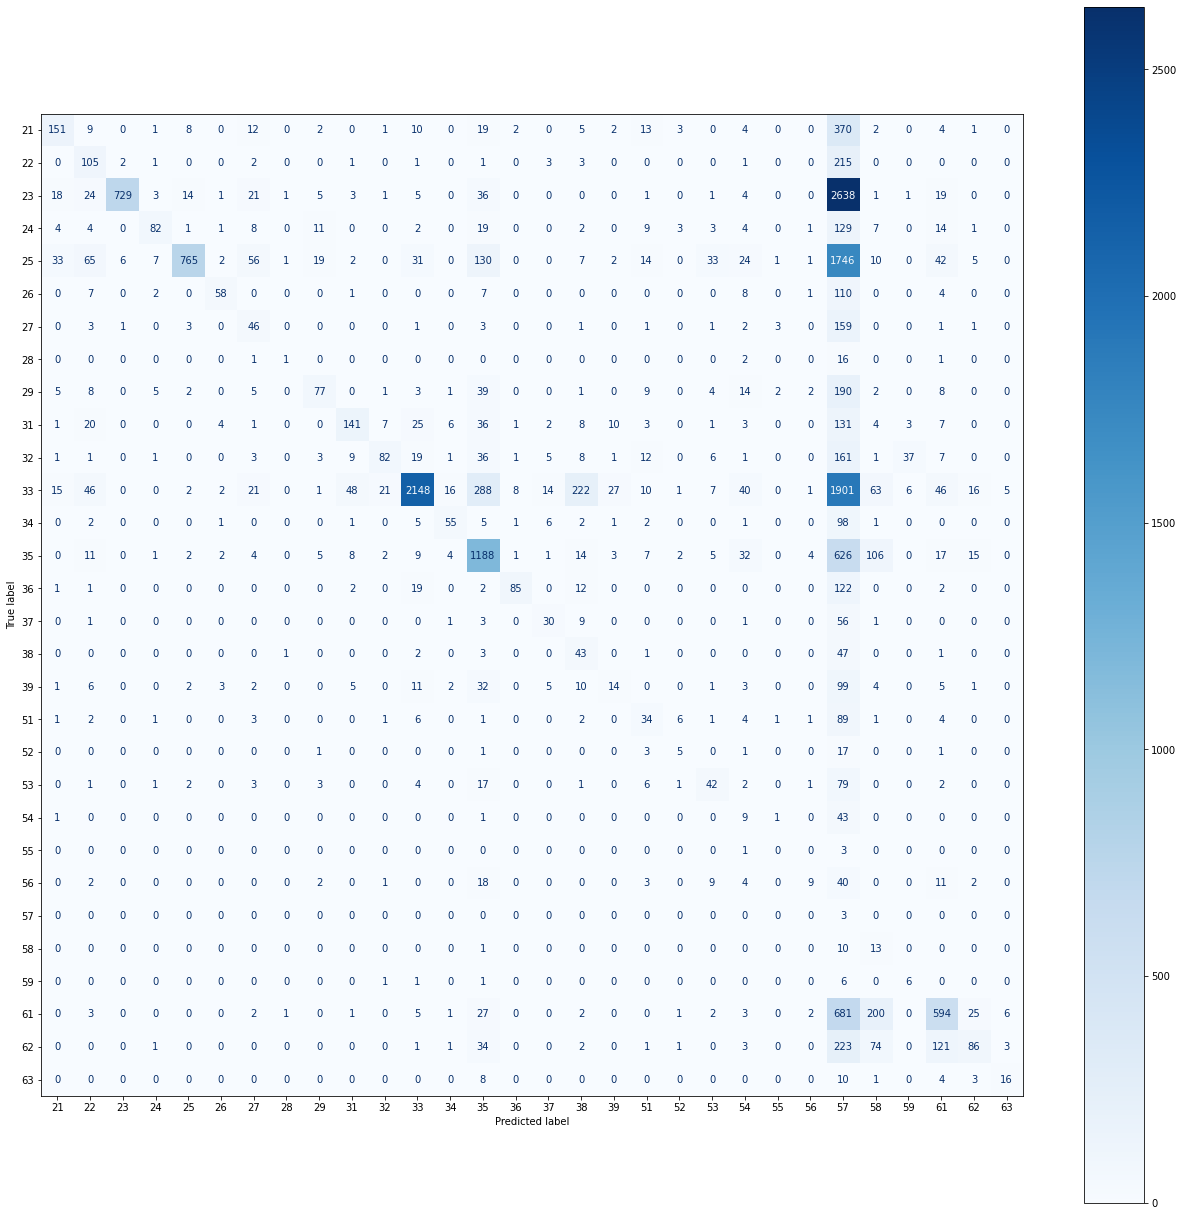

In [39]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##Otras pruebas

In [ ]:
# Classify algoritmo SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, random_state=0, probability=True)
# Entrenamiento del algoritmo 
SVM.fit(X_train_vec, y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [ ]:
#For large datasets consider using LinearSVC
model = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

NameError: ignored

In [ ]:
# Entrenamiento del algoritmo 
model.fit(X_train_vec, y_train)

NameError: ignored

In [ ]:
# Let's see the results
y_pred = SVM.predict(X_test_vec)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.92      0.94      0.93      4307
        3000       0.91      0.92      0.92      4298
        5000       0.81      0.32      0.46       284
        6000       0.90      0.90      0.90      1111

    accuracy                           0.91     10000
   macro avg       0.88      0.77      0.80     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = sbert_model.encode(df['descripcion'].values)
examples

In [ ]:
 #Prediction
test = model.predict(examples)
test

Accuracy del modelo ->  91.07
Porcentaje de acierto para cada una de las clases: 
              precision    recall  f1-score   support

        2000       0.92      0.94      0.93      4307
        3000       0.91      0.92      0.92      4298
        5000       0.81      0.32      0.46       284
        6000       0.90      0.90      0.90      1111

    accuracy                           0.91     10000
   macro avg       0.88      0.77      0.80     10000
weighted avg       0.91      0.91      0.91     10000

Matriz de confusion test: 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

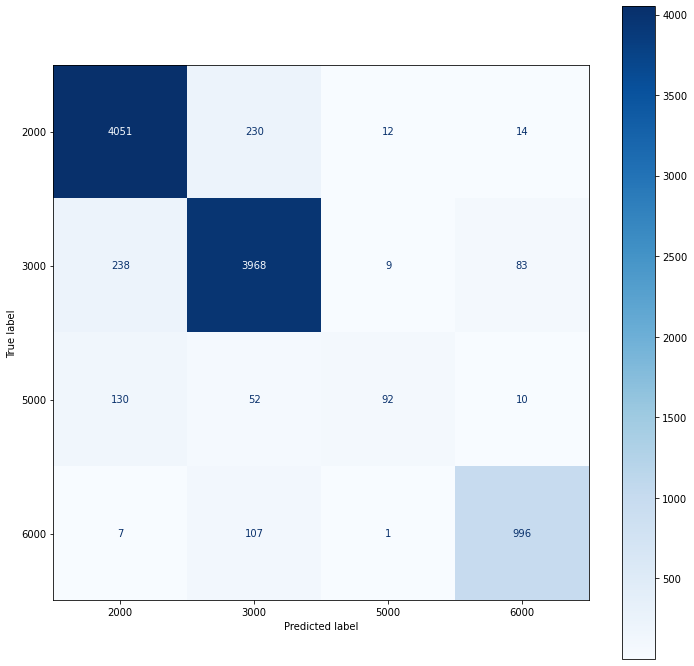

Matriz de confusion train: 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

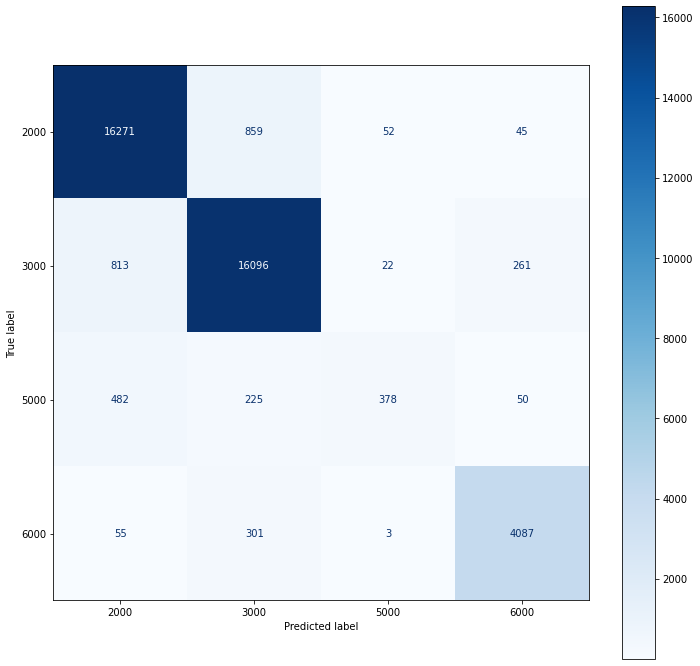

In [ ]:
# Evaluacion del modelo 
print("Accuracy del modelo -> ",metrics.accuracy_score(y_pred, y_test)*100)

print("Porcentaje de acierto para cada una de las clases: ")
print(metrics.classification_report(y_test, y_pred))

print("Matriz de confusion test: ")
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(SVM, X_test_vec, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

print("Matriz de confusion train: ")
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(SVM, X_train_vec, y_train, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 


In [ ]:
# Finally, let's try the examples again:
test = clf.predict(["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"])
test

array([2000, 2000, 3000, 2000, 2000, 2000])

In [ ]:
dfsample.groupby(['id_concepto']).count()

,id_capitulo,id_partida_generica,descripcion,clean_text
id_concepto,,,,
2100,807,807,807,807
2200,399,399,399,399
2300,4454,4454,4454,4454
2400,385,385,385,385
2500,3809,3809,3809,3809
2600,250,250,250,250
2700,298,298,298,298
2800,24,24,24,24
2900,443,443,443,443


In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = dfsample['clean_text'] # Text
Y = dfsample['id_concepto'] # Labels

In [ ]:
# Classify
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
clfConcepto = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('linearsvc', LinearSVC(random_state=42))
])
clfConcepto.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(random_state=42))])

In [ ]:
# Let's see the results
y_pred = clfConcepto.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2100       0.81      0.73      0.77       167
        2200       0.78      0.74      0.76        82
        2300       0.96      0.95      0.95       840
        2400       0.53      0.44      0.48        70
        2500       0.82      0.92      0.86       795
        2600       0.87      0.83      0.85        58
        2700       0.83      0.69      0.75        64
        2800       0.00      0.00      0.00         5
        2900       0.69      0.52      0.59        85
        3100       0.68      0.45      0.54       115
        3200       0.70      0.70      0.70        81
        3300       0.84      0.90      0.87      1211
        3400       0.77      0.63      0.69        43
        3500       0.82      0.88      0.85       503
        3600       0.79      0.76      0.77        49
        3700       0.86      0.58      0.69        31
        3800       0.50      0.27      0.35        26
        3900       0.36    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
